In [59]:
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [60]:
# Load the data
data = pd.read_csv('Documents/HASU Historical Data(2).csv')
print(data.head())

        Date  Price
0  6/20/2022   32.2
1  6/21/2022   33.0
2  6/22/2022   33.0
3  6/23/2022   33.0
4  6/24/2022   35.0


In [61]:
# Create a time index
data['Time'] = range(len(data))
print(data.head())

        Date  Price  Time
0  6/20/2022   32.2     0
1  6/21/2022   33.0     1
2  6/22/2022   33.0     2
3  6/23/2022   33.0     3
4  6/24/2022   35.0     4


In [62]:
# Calculate log returns
data['LogReturn'] = np.log(data['Price']) - np.log(data['Price'].shift(1))
data = data.dropna()  # Remove the first row which will have NaN value for LogReturn

print(data.head())


        Date  Price  Time  LogReturn
1  6/21/2022   33.0     1   0.024541
2  6/22/2022   33.0     2   0.000000
3  6/23/2022   33.0     3   0.000000
4  6/24/2022   35.0     4   0.058841
5  6/27/2022   35.1     5   0.002853


In [63]:
# Calculate drift and scale parameters
mu = data['LogReturn'].mean()
sigma = data['LogReturn'].std()

print(f"Drift Parameter (μ_GB): {mu - (sigma**2)/2}")
print(f"Scale Parameter (σ): {sigma}")

Drift Parameter (μ_GB): 0.0009176242371168226
Scale Parameter (σ): 0.023382021704588297


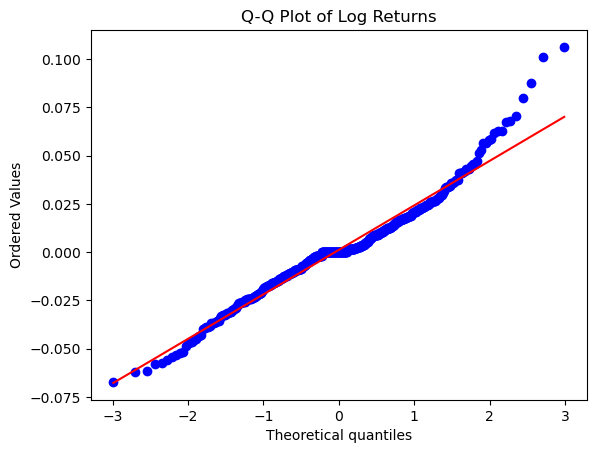

In [64]:
# Q-Q plot to check for normality of log returns
log_returns = data['LogReturn']

fig, ax = plt.subplots()
stats.probplot(log_returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Log Returns')
plt.show()

In [65]:
def BrownianG(m, T, N, sigma, mu, w0, GB=False):
    """
    Arguments
    m - Number of sample paths
    T - Total time
    sigma - Scale parameter
    N - Number of steps
    mu - Drift Parameter
    w0 - Starting value
    GB - Geometric Brownian Motion flag

    Returns
    ----
    numpy array with shape (m, N+1), where the first column gives the initial values of each path
    """
    dt = T / N
    x = np.zeros((m, N+1))
    x[:, 0] = w0
    if not GB:
        r = norm.rvs(size=(m, N), loc=mu*dt, scale=sigma*np.sqrt(dt))
        np.cumsum(r, axis=-1, out=x[:, 1:])
        x[:, 1:] += w0
    else:
        r = norm.rvs(size=(m, N), loc=(mu - (sigma**2 / 2)) * dt, scale=sigma * np.sqrt(dt))
        np.cumsum(r, axis=-1, out=x[:, 1:])
        if w0 != 0:
            x[:, 1:] = w0 * np.exp(x[:, 1:])
        else:
            x[:, 1:] = np.exp(x[:, 1:])
    return x

# Simulation parameters
S0 = data['Price'].iloc[-1]
T = 20
N = 20
M = 5000
paths = BrownianG(M, T, N, sigma, 0.0009176242371168226, S0, GB=True)


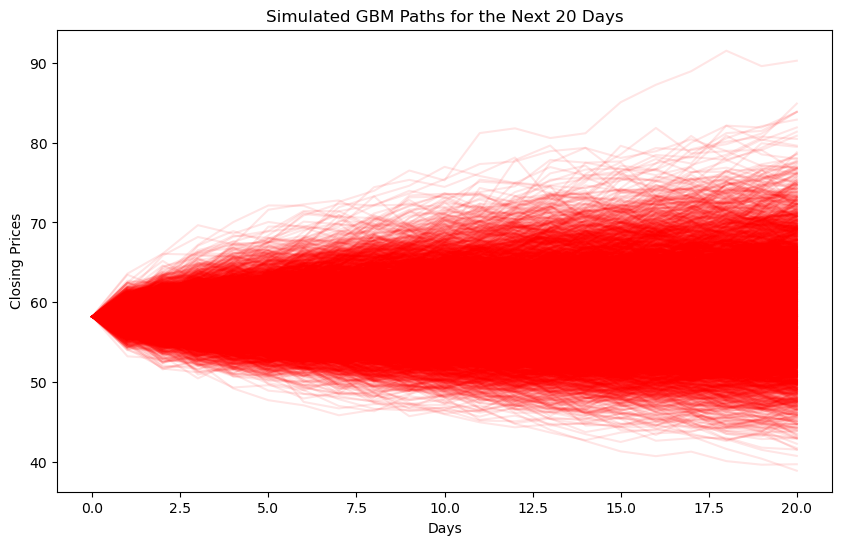

In [66]:
#Plotting the sample paths for the next 20 days.
plt.figure(figsize=(10, 6))
plt.plot(paths.T, color='red', alpha=0.1)
plt.title('Simulated GBM Paths for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.show()


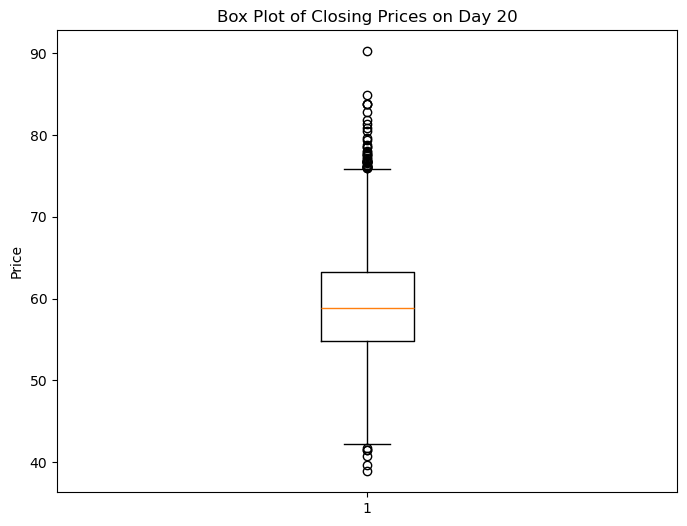

In [67]:
#Draw a box plot for the possible closing price values of HASU 
plt.figure(figsize=(8, 6))
plt.boxplot(paths[:, -1])
plt.title('Box Plot of Closing Prices on Day 20')
plt.ylabel('Price')
plt.show()


In [68]:

last_day_prices = paths[:, -1]
prob = np.mean((last_day_prices >= 55) & (last_day_prices <= 60))

print(f"Probability that the closing price is between 55 and 60: {prob}")


Probability that the closing price is between 55 and 60: 0.3122


In [69]:
lower_bound = np.percentile(last_day_prices, 2.5)
upper_bound = np.percentile(last_day_prices, 97.5)

print(f"95% Prediction Interval: [{lower_bound}, {upper_bound}]")


95% Prediction Interval: [47.68197357507028, 72.28584728238769]
